# IMPORTING

importing all required libraries and dataset

In [1]:
!pip install emoji
!pip install fsspec
!pip install gcsfs

     |████████████████████████████████| 133kB 19.0MB/s 
     |████████████████████████████████| 112kB 17.0MB/s 
     |████████████████████████████████| 1.3MB 20.3MB/s 
     |████████████████████████████████| 143kB 49.6MB/s 
     |████████████████████████████████| 296kB 50.8MB/s 


In [2]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_colwidth', -1)
from time import time
import re
import string
import os
import emoji
from pprint import pprint
import collections

import matplotlib.pyplot as plt


from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

import warnings
warnings.filterwarnings('ignore')

np.random.seed(37)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


In [3]:
train_data = pd.read_csv("gs://omar-ds-lab/ta-cw1/train.csv")

# Helper Functions

In [4]:
# Callback for plotting
# TODO: move this to a helper file

from tensorflow.keras.callbacks import Callback
from IPython.display import clear_output

# For plotting the learning curve in real time
class TrainingPlot(Callback):
    
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
        self.max_acc = 0
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_accuracy'))
        self.max_acc = max(self.max_acc, logs.get('val_accuracy'))
        
        # Before plotting ensure at least 2 epochs have passed
        if self.losses:
          if len(self.losses) > 1:
              
              # Clear the previous plot
              clear_output(wait=True)
              N = np.arange(0, len(self.losses))
              
              # Plot train loss, train acc, val loss and val acc against epochs passed
              plt.figure(figsize=(8,3))
              plt.plot(N, self.losses, lw=2, c="b", linestyle="-", label = "train_loss")
              plt.plot(N, self.acc, lw=2, c="r", linestyle="-", label = "train_acc")
              plt.plot(N, self.val_losses, lw=2, c="b", linestyle=":", label = "val_loss")
              plt.plot(N, self.val_acc, lw=2, c="r", linestyle=":", label = "val_acc")
              plt.title("Training Loss and Accuracy [Epoch {}, Max Acc {:.4f}]".format(epoch, self.max_acc))
              plt.xlabel("Epoch #")
              plt.ylabel("Loss/Accuracy")
              plt.legend()
              plt.show()
            
plot_losses = TrainingPlot()

In [5]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
def remove_mentions(input_text):
  return re.sub(r'@\w+', '', input_text)

def remove_urls(input_text):
  return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)

def emoji_oneword(input_text):
  # By compressing the underscore, the emoji is kept as one word
  return input_text.replace('_','')

def remove_punctuation(input_text):
  # Make translation table
  punct = string.punctuation
  trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
  return input_text.translate(trantab)

def remove_digits(input_text):
  return re.sub('\d+', '', input_text)

def to_lower(input_text):
  return input_text.lower()

def remove_stopwords(input_text):
  stopwords_list = stopwords.words('english')
  # Some words which might indicate a certain sentiment are kept via a whitelist
  whitelist = ["n't", "not", "no"]
  words = input_text.split() 
  clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
  return " ".join(clean_words) 

def stemming(input_text):
  porter = PorterStemmer()
  words = input_text.split() 
  stemmed_words = [porter.stem(word) for word in words]
  return " ".join(stemmed_words)

def fit(X, y=None, **fit_params):
  return self

def transform(X):
  clean_X = remove_mentions(X)
  clean_X = remove_urls(clean_X)
  clean_X = emoji_oneword(clean_X)
  clean_X = remove_punctuation(clean_X)
  clean_X = remove_digits(clean_X)
  clean_X = to_lower(clean_X)
  clean_X = remove_stopwords(clean_X)
  clean_X = stemming(clean_X)
  return clean_X

def text_clean(X):
  clean_X = remove_mentions(X)
  clean_X = remove_urls(clean_X)
  clean_X = emoji_oneword(clean_X)
  clean_X = remove_punctuation(clean_X)
  clean_X = remove_digits(clean_X)
  clean_X = to_lower(clean_X)
  clean_X = remove_stopwords(clean_X)
  #clean_X = stemming(clean_X)
  return clean_X

In [7]:
# Create an iterator object that returns words properly formatted for Word2Vec training
class ReviewsIterator:
    def __init__(self, dataset, text_column=0):
        self.dataset = dataset
        self.text_column = text_column

        # The text contains a stupid special character, hence the + '–'
        self.translator = str.maketrans('', '', string.punctuation + '–')

    def __iter__(self):
        for news in self.dataset.iloc[:, self.text_column]:
            # Make all characters lower-case
            news = news.lower()
            for sentence in news.split('.')[:-1]:
                # Clean string of all punctuation
                sentence = sentence.translate(self.translator)

                words = [w for w in sentence.split(' ') if w != '']

                yield words

# Data Preparation

In [8]:
#Variables
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 5000
embedding_dim = 64
max_length = 500
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8

In [9]:
train_data.head(1)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,220291,B0034EDLS2,AVF82BC7S0IO7,Kbrown,0,0,5,1332806400,Very Good,I received this product early from the seller! They are a very tastey & a Great mid-day snack. I have shared them with my Glutten Free Friends & they will be ordering this product & more very soon.


In [10]:
train_data['length'] = train_data['Text'].apply(len)
train_data.head(1)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,length
0,220291,B0034EDLS2,AVF82BC7S0IO7,Kbrown,0,0,5,1332806400,Very Good,I received this product early from the seller! They are a very tastey & a Great mid-day snack. I have shared them with my Glutten Free Friends & they will be ordering this product & more very soon.,197


In [11]:
train_data['Cleaned'] = train_data['Text'].apply(text_clean)
train_data['Cleaned'][0]

'received product early seller tastey great mid day snack shared glutten free friends ordering product soon'

In [12]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(train_data, test_size=0.2)
train_x = train['Cleaned']
train_y = train['Score']
validate_x = test['Cleaned']
validate_y = test['Score']

In [13]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_x)
word_index = tokenizer.word_index
dict(list(word_index.items())[0:10])

{'<OOV>': 1,
 'br': 2,
 'coffee': 9,
 'good': 5,
 'great': 8,
 'like': 4,
 'not': 3,
 'one': 6,
 'product': 10,
 'taste': 7}

In [14]:
train_x_sequences = tokenizer.texts_to_sequences(train_x)
validate_x_sequences = tokenizer.texts_to_sequences(validate_x)
train_x_padded = pad_sequences(train_x_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
validate_x_padded = pad_sequences(validate_x_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [15]:
print(len(train_x_sequences[0]))
print(len(validate_x_padded[0]))

print(len(train_x_sequences[1]))
print(len(validate_x_padded[1]))

print(len(train_x_sequences[10]))
print(len(validate_x_padded[10]))

25
500
27
500
17
500


In [16]:
test_data = pd.read_csv('gs://omar-ds-lab/ta-cw1/test.csv')
test_labels = pd.read_csv('gs://omar-ds-lab/ta-cw1/labels.csv')

In [17]:
test_data['Cleaned'] = test_data['Text'].apply(text_clean)
test_data['Cleaned'][0]

'fog chaser best flavor body far product body compatible richer flavor blew coffee uses cup system'

In [18]:
test_final_sequences = tokenizer.texts_to_sequences(test_data['Cleaned'])
test_final_padded = pad_sequences(test_final_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# QUESTION 5

splitting the data into train test set

In [ ]:
model = tf.keras.Sequential([
    # Add an Embedding layer expecting input vocab of size 5000, and output embedding dimension of size 64 we set at the top
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
#    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # use ReLU in place of tanh function since they are very good alternatives of each other.
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    # Add a Dense layer with 6 units and softmax activation.
    # When we have multiple outputs, softmax convert outputs layers into a probability distribution.
    tf.keras.layers.Dense(6, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          320000    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 390       
Total params: 394,694
Trainable params: 394,694
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


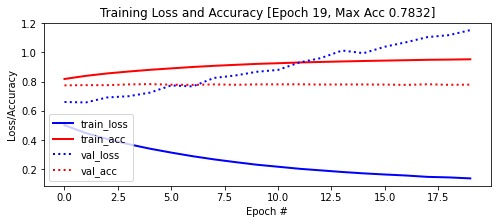

In [ ]:
num_epochs = 20
history = model.fit(train_x_padded, train_y, epochs=num_epochs, validation_data=(validate_x_padded, validate_y), verbose=2, callbacks=[plot_losses])

In [ ]:
preds = model.predict(test_final_padded)
scores = model.evaluate(preds, test_labels['Score'], verbose=0)
scores

[1.2821413278579712, 0.6377274394035339]

# RESEARCH QUESTION

In [19]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

reviews_lines = list()

lines = train_data['Cleaned'].values.tolist()

for line in lines:
  tokens = word_tokenize(line)
  tokens = [word.lower() for word in tokens]
  table = str.maketrans('','',string.punctuation)
  stripped = [w.translate(table) for w in tokens]
  words = [word for word in stripped if word.isalpha()]
  stop_words = set(stopwords.words('english'))
  words = [w for w in words if not w in stop_words]
  words = [w for w in words if not w == 'br']
  reviews_lines.append(words)

In [20]:
import gensim
# Train Word2Vec model with gensim on the dataset
w2v_model = gensim.models.Word2Vec(sentences=reviews_lines, size=100, window=5, min_count=10, workers=8)


In [21]:
# Retrieve the weights from the model. This is used for initializing the weights
# in a Keras Embedding layer later
w2v_weights = w2v_model.wv.vectors
vocab_size, embedding_size = w2v_weights.shape

print("Vocabulary Size: {} - Embedding Dim: {}".format(vocab_size, embedding_size))

# Some validation on the quality of the Word2Vec model
# print(w2v_model.wv.most_similar('1', topn=3))
print(w2v_model.wv.most_similar('movie', topn=3))
print(w2v_model.wv.most_similar('cinema', topn=3))
# print(w2v_model.wv.most_similar('ufsc', topn=3))
# print(w2v_model.wv.most_similar(positive=['rei', 'mulher'], negative=['homem'], topn=3))

def word2token(word):
    try:
        return w2v_model.wv.vocab[word].index
    # If word is not in index return 0. I realize this means that this
    # is the same as the word of index 0 (i.e. most frequent word), but 0s
    # will be padded later anyway by the embedding layer (which also
    # seems dirty but I couldn't find a better solution right now)
    except KeyError:
        return 0
def token2word(token):
    return w2v_model.wv.index2word[token]

Vocabulary Size: 25774 - Embedding Dim: 100
[('movies', 0.7719498872756958), ('theater', 0.6902551651000977), ('theatre', 0.6693642139434814)]
[('krema', 0.668642520904541), ('underworld', 0.6511737108230591), ('pasadena', 0.6465137004852295)]


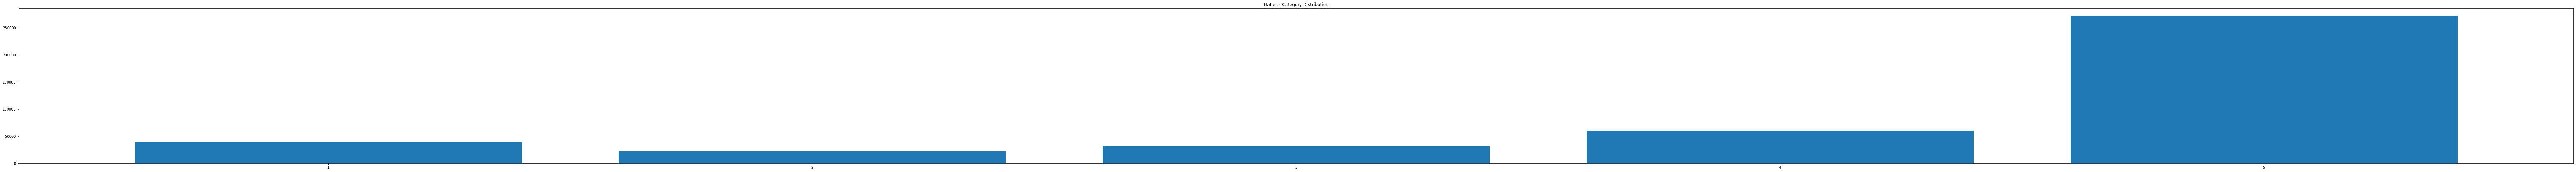

In [22]:
# First let's visualize the distribution of categories in the dataset
categories, ccount = np.unique(train_data.Score, return_counts=True)

# Using a figsize this big seems dirty. It's the only way I figured to make
# the x labels not overlap. I suck at plotting, sorry
plt.figure(figsize=(128, 8))
plt.title("Dataset Category Distribution")
plt.bar(categories, ccount, align='center')
plt.show()

In [23]:
df = pd.DataFrame()
df['text'] = train_data['Cleaned']
df['category'] = train_data['Score']

In [24]:
# Create an iterator that formats data from the dataset proper for
# LSTM training

# Sequences will be padded or truncated to this length
MAX_SEQUENCE_LENGTH = 200

# Samples of categories with less than this number of samples will be ignored
DROP_THRESHOLD = 10000

class SequenceIterator:
    def __init__(self, dataset, drop_threshold, seq_length):
        self.dataset = dataset

        self.translator = str.maketrans('', '', string.punctuation + '–')
        self.categories, self.ccount = np.unique(dataset.category, return_counts=True)
        
        self.seq_length = seq_length
        
        # Samples of categories with less than this number of samples will be ignored
        self.drop_categos = []
        for cat, count in zip(self.categories, self.ccount):
            if count < drop_threshold:
                self.drop_categos.append(cat)
        
        # Remaining categories
        self.categories = np.setdiff1d(self.categories, self.drop_categos)
        
    def __iter__(self):
        for news, cat in zip(self.dataset.iloc[:, 0], self.dataset.iloc[:, 1]):
            if cat in self.drop_categos:
                continue
            
            # Make all characters lower-case
            news = news.lower()
            
            # Clean string of all punctuation
            news = news.translate(self.translator)

            words = np.array([word2token(w) for w in news.split(' ')[:self.seq_length] if w != ''])
                                
            yield (words, cat)

sequences = SequenceIterator(df, DROP_THRESHOLD, MAX_SEQUENCE_LENGTH)

# Used for generating the labels in the set
cat_dict = {k: v for k, v in zip(sequences.categories, range(len(sequences.categories)))}

set_x = []
set_y = []
for w, c in sequences:
    set_x.append(w)
    set_y.append(cat_dict[c])
    
# Padding sequences with 0.
set_x = pad_sequences(set_x, maxlen=MAX_SEQUENCE_LENGTH, padding='pre', value=0)
set_y = np.array(set_y)

print(set_x.shape)
print(set_y.shape)

(426340, 200)
(426340,)


Train Shapes - X: (362389, 200) - Y: (362389,)
Val Shapes - X: (63951, 200) - Y: (63951,)


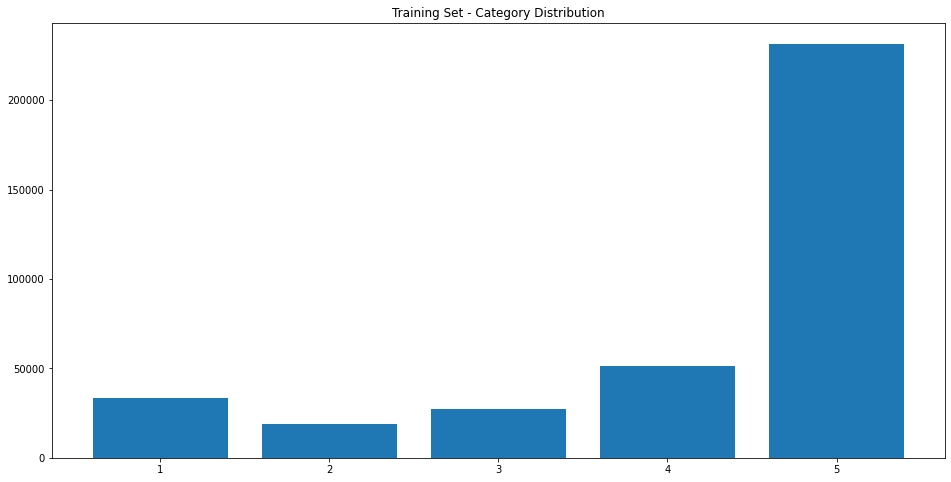

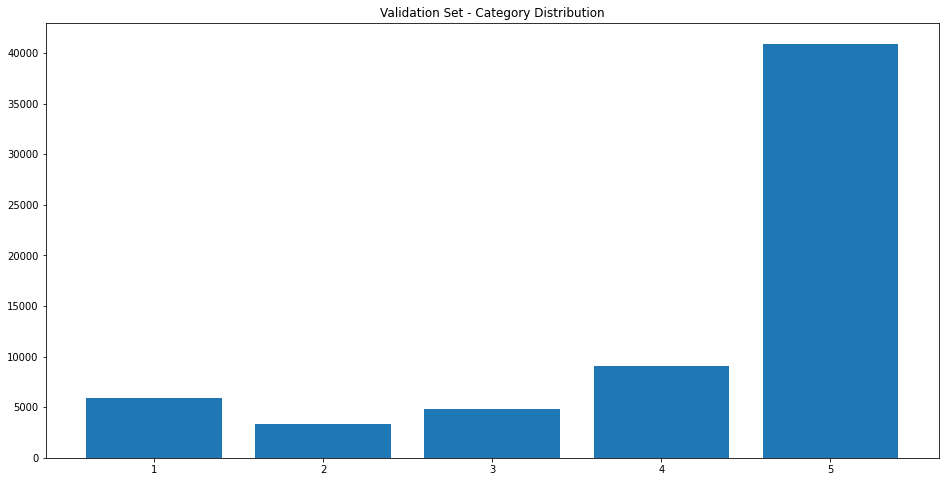

In [25]:
import random

VALID_PER = 0.15 # Percentage of the whole set that will be separated for validation

total_samples = set_x.shape[0]
n_val = int(VALID_PER * total_samples)
n_train = total_samples - n_val

random_i = random.sample(range(total_samples), total_samples)
train_x = set_x[random_i[:n_train]]
train_y = set_y[random_i[:n_train]]
val_x = set_x[random_i[n_train:n_train+n_val]]
val_y = set_y[random_i[n_train:n_train+n_val]]

print("Train Shapes - X: {} - Y: {}".format(train_x.shape, train_y.shape))
print("Val Shapes - X: {} - Y: {}".format(val_x.shape, val_y.shape))

# Let's look at the distribution of categories in both sets
categories, ccount = np.unique(train_y, return_counts=True)
plt.figure(figsize=(16, 8))
plt.title("Training Set - Category Distribution")
plt.xticks(range(len(categories)), cat_dict.keys())
plt.bar(categories, ccount, align='center')
plt.show()

categories, ccount = np.unique(val_y, return_counts=True)
plt.figure(figsize=(16, 8))
plt.title("Validation Set - Category Distribution")
plt.xticks(range(len(categories)), cat_dict.keys())
plt.bar(categories, ccount, align='center')
plt.show()

n_categories = len(categories)

In [26]:
model_w2v = tf.keras.Sequential([
    # Add an Embedding layer expecting input vocab of size 5000, and output embedding dimension of size 64 we set at the top
    tf.keras.layers.Embedding(input_dim=vocab_size,
                    output_dim=embedding_size,
                    weights=[w2v_weights],
                    input_length=MAX_SEQUENCE_LENGTH,
                    mask_zero=True,
                    trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_size)),
#    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # use ReLU in place of tanh function since they are very good alternatives of each other.
    # tf.keras.layers.Dense(embedding_dim, activation='relu'),
    # Add a Dense layer with 6 units and softmax activation.
    # When we have multiple outputs, softmax convert outputs layers into a probability distribution.
    tf.keras.layers.Dense(n_categories, activation='softmax')
])
model_w2v.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_w2v.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 100)          2577400   
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               160800    
_________________________________________________________________
dense (Dense)                (None, 5)                 1005      
Total params: 2,739,205
Trainable params: 161,805
Non-trainable params: 2,577,400
_________________________________________________________________


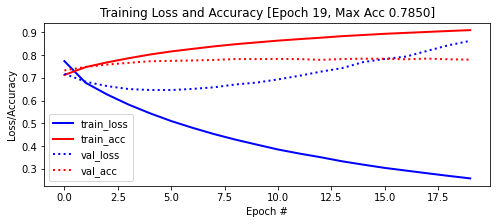

In [27]:
num_epochs = 20
history = model_w2v.fit(train_x, train_y, epochs=num_epochs, validation_data=(val_x, val_y), batch_size=512, verbose=2, callbacks=[plot_losses])

In [28]:
preds = model_w2v.predict(test_final_padded)
scores = model_w2v.evaluate(preds, test_labels['Score'], verbose=0)
scores

[nan, 0.14316675066947937]

In [29]:
print("%s: %.2f%%" % (model_w2v.metrics_names[1], scores[1]*100))

accuracy: 14.32%
